In [9]:
import sys
sys.path.append("/home/dictus/bakdmt/v2")
from neuro_dmt.library.users.hugo.validations import SimpleValidation

In [10]:
from dmt.model.interface import Interface
from neuro_dmt.library.users.hugo.adapters import PRESYNAPTIC, POSTSYNAPTIC, SYN_CLASS
from neuro_dmt.library.users.hugo.utils import MEAN
import pandas as pd
from seaborn import heatmap
import numpy as np


def hplot(label, df):
    from dmt.tk.plotting.utils import pivot_table
    df_matrix, _, __ = pivot_table(df, PRESYNAPTIC, POSTSYNAPTIC, MEAN)
    fig = heatmap(df_matrix, cbar=True, cmap='rainbow')
    return fig

# note that this is NOT intended usage
def cplot(labels, results_dataframes):
    import imp
    from dmt.tk.plotting import circle
    imp.reload(circle)
    CirclePlot = circle.CirclePlot
    fig, ax = CirclePlot(space_between=0.02, color_callback=custom_color_callback,
                         min_conn_size=0.005, value_callback=custom_label_callback).plot(results_dataframes[0])
    ax.set_title(labels[0])
    return ax

# TODO: rename value_callback to label_callback
# TODO: callback should not recieve 'pre'
def custom_label_callback(row):
    row = row.get('pre', row)
    row = row.get('post', row)
    layer = row['layer'][0][0]
    return "{}_{}".format("L23" if layer == "L2" else layer, row['mtype'][0])

layer_to_hue = {
    "L2": np.array((220/255, 224/255, 34/255, 1.0)),
    "L1": np.array((129/255, 83/255, 120/255, 1.0)),
    "L4": np.array((91/255, 165/255, 217/255, 1.0)),
    "L5": np.array((255/255, 35/255, 40/255, 1.0)),
    "L6": np.array((140/255, 208/255, 105/255, 1.0))
}

# TODO: it would be best for groups to be converted back to dicts, as it seems
#       pandas rows do not adequately mimic them
def custom_color_callback(groups):
    import matplotlib
    cmap = matplotlib.cm.get_cmap('gist_rainbow')
    layers = list(pd.DataFrame(list(groups.values())).layer[0].unique())
    nlayers = len(layers)
    max_color = nlayers - 1

    return {grp: {
        'fc':
            tuple(
                v for v in (
                    layer_to_hue[params['layer'][0][0]]
                    * (np.array([0.5, 0.5, 0.5, 1.0])
                       if 'INH' == params['sclass'][0] else
                       np.array([1.0, 1.0, 1.0, 1.0])))),
        'ec': (0.0, 0.0, 0.0, 1.0)}
        for grp, params in groups.items()}

# TODO: when asking for mtypes, include 'properties' argument
#       defaulting to 'mtype', but possibly requesting 'base_mtype', 'layer', 'sclass', 'etype'(would return list) etc.
# current solution is a hack
def by_mtype(model):
    """
    gets the available mtypes from the model
    effectively makes this a 'by mtype' validation
    """
    from collections import OrderedDict
    mtypes = model.mtypes()
    
    def sclass_of(mtype, layer):
        from bluepy.v2 import Cell
        mt = "_".join([layer if isinstance(layer, str) else 'L23', mtype])
        return model._circuit.cells.get({Cell.MTYPE: mt}, properties=[Cell.SYNAPSE_CLASS]).iloc[0]
    
    mtype_groups = [OrderedDict([('layer', mt['layer']), (SYN_CLASS, sclass_of(**mt)), ('mtype', mt['mtype'])])
                                 for mt in mtypes]
    
    layer_key = {'L1': 1, "['L2', 'L3']": 2, 'L4': 3, 'L5': 5, 'L6': 6}
    sclass_key = {'EXC': 1, 'INH': 2}
    
    mtype_groups = sorted(mtype_groups, key = lambda g: 3 * layer_key[str(g['layer'])] + sclass_key[g['sclass']])
    return [OrderedDict([(PRESYNAPTIC, pre), (POSTSYNAPTIC, post)])
            for post in mtype_groups for pre in mtype_groups]


class SynapsesPerConnectionAnalysis(SimpleValidation):
    
    class AdapterInterface(Interface):
        
        def synapses_per_connection(model, parameters):
            """
            get the number of synapses per connection from the model
            for the pathway defined be pre and post mtype
            
            Arguments:
                model: the model to get the data from
                pre_mtype: string, the presynaptic mtype
                post_mtype: string, the postsynaptic mtype
            
            Returns:
                Array: number of synapses for each connection sampled
            """
            raise NotImplementedError
    

    
    def get_measurement(self, model, parameters):
        """
        get the measurement from the model
        Arguments:
            parameters: dict with keys PRESYNAPTIC and POSTSYNAPTIC
                        and values which are each a set of parameters
                        for pre and postsynaptic cells
        """
        return model.synapses_per_connection(parameters) 
        
    def plot(self, labels, results_dataframes):
        return hplot(labels[0], results_dataframes[0])


class ByMtypeSynapsesPerConnectionAnalysis(SynapsesPerConnectionAnalysis):
    
    class AdapterInterface(SynapsesPerConnectionAnalysis.AdapterInterface):
        
        def mtypes(model):
            """
            get all of the mytpes in the model
            Arguments:
               model: the model to get mtypes from
            
            Returns:
               iterable of mtypes (string)
            """
            raise NotImplementedError
            
    def measurements_parameters(self, model):
        """{}""".format(by_mtype.__doc__)
        return by_mtype(model)

In [11]:
import numpy as np

class DummyAdapter:
    
    label = 'dummy model'
    
    def synapses_per_connection(self, params):
        return np.random.poisson(np.random.poisson(10), 1 + np.random.poisson(1))
    
    def mtypes(self):
        return [{'mtype': letter} for letter in ['aaaaaaaa', 'bbbbbbbb', 'cccccccc', 'dddddd', 'eeeeeeee', 'fffffff']]
    

In [12]:
print(DummyAdapter().synapses_per_connection(''),
DummyAdapter().synapses_per_connection(''),
DummyAdapter().synapses_per_connection(''),
DummyAdapter().synapses_per_connection(''))

[17 12] [7] [8 7] [9]


/home/dictus/bakdmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:43: Warning: <__main__.ByMtypeSynapsesPerConnectionAnalysis object at 0x7fa3e3bce208> does not have a phenomenon, defaulting to 'Not Provided'
  .format(self)))


plotting


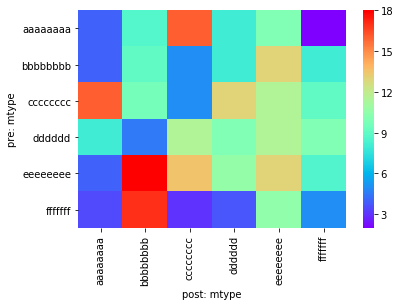

In [13]:
analysis = ByMtypeSynapsesPerConnectionAnalysis()
analysis.measurements_parameters=lambda model: [{PRESYNAPTIC: pre, POSTSYNAPTIC: post} for post in model.mtypes() for pre in model.mtypes()] 
report = analysis(DummyAdapter())

In [14]:

class ConnectionProbabilityAnalysis(SimpleValidation):
    
    class AdapterInterface(Interface):
        
        def connection_probability(model, parameters):
            """
            get the probability of a connection between cells
            
            Arguments:
                model: the adapted model to extract data from
                parameters: dict with 'pre' and 'post' parameter sets
            
            Returns:
                Array: number of synapses for each connection sampled
            """
            raise NotImplementedError
    
    def get_measurement(self, model, parameters):
        """
        get the measurement from the model
        """
        return model.connection_probability(parameters, sample_size=10, nsamples=100)
       
        
    def plot(self, labels, results_dataframes):
        return hplot(labels[0], results_dataframes[0])
 
# TODO: there is some code duplication here. will be fixed once measurements_parameters is a component
class ByMtypeConnectionProbabilityAnalysis(ConnectionProbabilityAnalysis):
    
    class AdapterInterface(ConnectionProbabilityAnalysis.AdapterInterface):
        
        def mtypes(model):
            """
            get all of the mytpes in the model
            Arguments:
               model: the model to get mtypes from
            
            Returns:
               iterable of mtypes (string)
            """
            raise NotImplementedError
        
    def measurements_parameters(self, model):
        """{}""".format(by_mtype.__doc__)
        return by_mtype(model)

In [15]:

class PathwaySynapsesAnalysis(SimpleValidation):
    
    class AdapterInterface(Interface):
        
        def pathway_synapses(model, parameters):
            """
            get the total number of synapses on one group of cells from another
            
            Arguments:
                model: the adapted model to extract data from
                parameters: dict with 'pre' and 'post' parameter sets
            
            Returns:
                Array: number of synapses for each connection sampled
            """
            raise NotImplementedError
    
    def get_measurement(self, model, parameters):
        """
        get the measurement from the model
        """
        # TODO: sample size of pathway_synapses should be proportional to the total
        #       number of cells, and/or the result scaled up by pop_size/sample_size 
        return model.pathway_synapses(parameters, nsamples=None, sample_size=None)
       
        
    def plot(self, labels, results_dataframes):
        return cplot(labels, results_dataframes)
 
# TODO: there is some code duplication here. will be fixed once measurements_parameters is a component
class ByMtypePathwaySynapsesAnalysis(PathwaySynapsesAnalysis):
    
    class AdapterInterface(PathwaySynapsesAnalysis.AdapterInterface):
        
        def mtypes(model):
            """
            get all of the mytpes in the model
            Arguments:
               model: the model to get mtypes from
            
            Returns:
               iterable of mtypes (string)
            """
            raise NotImplementedError
        
    def measurements_parameters(self, model):
        """{}""".format(by_mtype.__doc__)
        return by_mtype(model)

from neuro_dmt.library.users.hugo.adapters import CircuitAdapter

In [16]:

bmspcreport = ByMtypeSynapsesPerConnectionAnalysis()(CircuitAdapter("/gpfs/bbp.cscs.ch/project/proj1/circuits/SomatosensoryCxS1-v5.r0/O1/merged_circuit/CircuitConfig"))

/home/dictus/bakdmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:43: Warning: <__main__.ByMtypeSynapsesPerConnectionAnalysis object at 0x7fa3dc21a400> does not have a phenomenon, defaulting to 'Not Provided'
  .format(self)))
/home/dictus/bakdmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:210: UserWarning: model number 0, <neuro_dmt.library.users.hugo.adapters.CircuitAdapter object at 0x7fa3dc21a128> does not have label
  .format(i, model))


plotting: 99.97%


ValueError: Image size of 177263x177258 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 2 Axes>

In [ ]:
bmcpreport = ByMtypeConnectionProbabilityAnalysis()(CircuitAdapter("/gpfs/bbp.cscs.ch/project/proj1/circuits/SomatosensoryCxS1-v5.r0/O1/merged_circuit/CircuitConfig"))

/home/dictus/bakdmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:43: Warning: <__main__.ByMtypeConnectionProbabilityAnalysis object at 0x7fa3b6e29898> does not have a phenomenon, defaulting to 'Not Provided'
  .format(self)))
/home/dictus/bakdmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:210: UserWarning: model number 0, <neuro_dmt.library.users.hugo.adapters.CircuitAdapter object at 0x7fa3b7a8f4a8> does not have label
  .format(i, model))


plotting: 99.97%


ValueError: Image size of 177263x177258 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 2 Axes>

In [ ]:
bmpsreport = ByMtypePathwaySynapsesAnalysis()(CircuitAdapter("/gpfs/bbp.cscs.ch/project/proj1/circuits/SomatosensoryCxS1-v5.r0/O1/merged_circuit/CircuitConfig"))

/home/dictus/bakdmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:43: Warning: <__main__.ByMtypePathwaySynapsesAnalysis object at 0x7fa3b20efc88> does not have a phenomenon, defaulting to 'Not Provided'
  .format(self)))
/home/dictus/bakdmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:210: UserWarning: model number 0, <neuro_dmt.library.users.hugo.adapters.CircuitAdapter object at 0x7fa3b20eff98> does not have label
  .format(i, model))


In [ ]:
import imp
from dmt.tk.plotting import circle
from dmt.tk.plotting import utils
imp.reload(utils)
imp.reload(circle)
bmpsreport.data_results[0][1]

f = cplot([bmpsreport.data_results[0][0]], [bmpsreport.data_results[0][1]])
